### Step 1: Loading the label matrix

In [1]:
import pandas as pd
import numpy as np

# Load csv
DATA_FILEPATH = 'clicks_20180413.csv'
L_data = pd.read_csv(DATA_FILEPATH)
N = L_data.shape[0]

L_data[:5]

,EventId,positive_labels,negative_labels
0,86752b453d75db9dd6e7c697df249eb4e75070f1,1,"0,14,3,2"
1,0ab3a9ba5d65ae7e8449d87e27679ae8be6d570a,1,"6,2"
2,0c31aec0a9d1ca720e474f5c03299b545b7bf87b,"5,11","14,3,6"
3,e542ac25db7ce2aafb7d47303e0169e012468967,8,14
4,b401cc41e8792fbcc326991cccd3356e2b556617,NaN,"0,14,3,2"


In [2]:
from itertools import chain
from scipy.sparse import lil_matrix

# Get the pos/neg LF idxs, total number M
def split_lf_idxs(x):
    return map(int, x.split(',')) if isinstance(x, str) else []

def get_lf_idxs(col):
    return set(chain.from_iterable([split_lf_idxs(x) for x in col]))

lf_pos_idxs = get_lf_idxs(L_data.iloc[:,1])
lf_neg_idxs = get_lf_idxs(L_data.iloc[:,2])
M = max(lf_pos_idxs | lf_neg_idxs) + 1

# Construct COO sparse matrix
# Note: Skip LF #5
SKIP_LFS = [5]
L = lil_matrix((N, M))
for i, row in L_data.iterrows():
    for j in split_lf_idxs(row['positive_labels']):
        if j not in SKIP_LFS:
            L[i, j] = 1
    for j in split_lf_idxs(row['negative_labels']):
        if j not in SKIP_LFS:
            L[i, j] = -1

# Convert to CSR matrix
L = L.tocsr()
L

<1762247x58 sparse matrix of type '<class 'numpy.float64'>'
	with 4653672 stored elements in Compressed Sparse Row format>

In [3]:
# Get the list of polarities
polarities = [1 if i in lf_pos_idxs else -1 for i in range(M)]

### Step 2: Loading the eval data

The eval data is keyed by the label signature, in format "<pos LFs> vs. <neg LFs>". So we need to parse this, then map it to `L` to get `Y`

In [4]:
LABELS_FILEPATH = 'grades_20180413.csv'
Y_data = pd.read_csv(LABELS_FILEPATH)

Y_data[:10]

,all_labels:string,Count:long,GradeAWithCI:string,GradeB:double,GradeC:double
0,"vs 0,3,2",277921,"0.890 (0.784, 1.006)",0.930620,0.978151
1,"vs 0,3",251344,"0.784 (0.672, 0.909)",0.882005,0.977887
2,vs 0,93997,"0.950 (0.773, 1.155)",1.083355,0.980390
3,"vs 0,2",61460,"1.202 (0.979, 1.461)",1.176954,0.974563
4,vs 3,60080,"0.880 (0.638, 1.184)",0.921943,0.938740
5,"4,5 vs 0,3,2",54063,"0.802 (0.573, 1.092)",0.782195,0.913637
6,"9 vs 0,3,2",49479,"1.339 (1.073, 1.651)",0.947844,0.955774
7,"4,5 vs 0,3",46559,"0.486 (0.289, 0.769)",0.774299,0.924639
8,"9 vs 0,3",40658,"1.354 (1.002, 1.790)",0.929188,0.956898
9,vs 2,37396,"0.864 (0.637, 1.146)",1.148264,0.956741


In [5]:
def split_labels_signature(x):
    idxs = []
    for z in x.split(' vs '):
        zs = z.split(',')
        if len(zs) > 1:
            idxs += map(int, zs)
    return idxs

def Y_data_to_dict(yd):
    """Convert the labels csv data -> dictionary of scores, keyed by LF voting signature."""
    labels_dict = {}
    for i, row in Y_data.iterrows():
        k = ','.join(map(str, split_labels_signature(row['all_labels:string'])))
        labels_dict[k] = [
            float(row['GradeAWithCI:string'].split(' (')[0]), # For now drop CI...
            float(row['GradeB:double']),
            float(row['GradeC:double']),
        ]
    return labels_dict

In [6]:
labels_dict = Y_data_to_dict(Y_data)

In [7]:
event_scores = {}
for i in range(L.shape[0]):
    k = ','.join(map(str, L[i].nonzero()[1]))
    if k in labels_dict:
        event_scores[i] = labels_dict[k]

In [8]:
def get_binary_labels(event_scores, N, pos_thresh=0.5, neg_thresh=0.9):
    """Get binary labels for each even based on the following thresholding:
    - GradeC < pos_thresh ==> spam
    - GradeC > neg_thresh ==> !spam
    """
    Y = np.zeros(N)
    for i, grades in event_scores.items():
        A, B, C = grades
        if C < pos_thresh:
            Y[i] = 1
        elif C > neg_thresh:
            Y[i] = -1
    return Y

In [65]:
Y = get_binary_labels(event_scores, L.shape[0], pos_thresh=0.5, neg_thresh=0.9)
Y.shape

(1762247,)

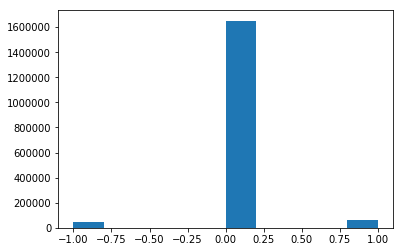

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(Y)
plt.show()

In [11]:
# def score_marginals(yp):
#     """Compute squared error w.r.t. the scores.
#     Currently doing Grade C for simplicity.
#     """
#     score = 0
#     count = 0
#     for i in range(yp.shape[0]):
#         if i in event_scores:
#             A, B, C = event_scores[i]
#             count += 1
            
#             # Grade C score ~= P(not spam)
#             # Compare to predicted marginals which is P(spam)
#             score += 1 - np.abs((1-yp[i]) - C)
#     return score / count

### Metrics

In [12]:
from sklearn import metrics as sklearn_metrics
import numpy as np
from scipy.sparse import issparse
import torch

def _to_array(array_like):
    """Convert a 1d array-like (e.g,. list, tensor, etc.) to an np.ndarray"""

    orig_type = type(array_like)
    
    # Convert to np.ndarray
    if isinstance(array_like, np.ndarray):
        pass
    elif isinstance(array_like, list):
        array_like = np.array(array_like)
    elif issparse(array_like):
        array_like = array_like.toarray()
    elif isinstance(array_like, torch.Tensor):
        array_like = array_like.numpy()
    elif not isinstance(array_like, np.ndarray):
        array_like = np.array(array_like)
    else:
        raise ValueError(f"Input of type {orig_type} could not be converted "
            "to 1d np.ndarray")
        
    # Correct shape
    if (array_like.ndim > 1) and (1 in array_like.shape):
        array_like = array_like.flatten()
    if array_like.ndim != 1:
        raise ValueError("Input could not be converted to 1d np.array")

    # Convert to ints
    if any(array_like % 1):
        raise ValueError("Input contains at least one non-integer value.")
    array_like = array_like.astype(np.dtype(int))

    return array_like


def _infer_labels(labels, pred, null_label=0):
    if labels is None:
        labels = sorted(list(set(pred) - set([null_label])))
    elif isinstance(labels, int) or isinstance(labels, str):
        labels = [labels]
    return labels

def _drop_gold_zeros(gold, pred, null_label=0):
    """Remove from gold and pred all items where gold is zero."""
    nonzeros = (np.where(gold != null_label, 1, 0)).astype(bool)
    gold = gold[nonzeros]
    pred = pred[nonzeros]
    return gold, pred


def fbeta_score(gold, pred, beta=1.0, labels=None, null_label=0, pos_label=1, 
        average=None, asdict=False, local=False, **kwargs):
    """
    Calculate f-beta.
    Args:
        gold: A 1d array-like of gold labels
        pred: A 1d array-like of predicted labels (assuming abstain = 0)
        labels: The list of labels for which to calculate f-beta 
            default is all non-zero labels in pred
        average: How to average returned f-betas [None, 'micro', 'macro', 'binary']
            if None, return dict of label-conditional f-betas for each label
    Returns:
        A float f-beta score if average is not None or (len(labels) == 1 and 
            asdict=False). Otherwise, a dict of f-betas by label ({label: f-beta})
    """
    pred = _to_array(pred)
    gold = _to_array(gold)
    if local:
        gold, pred = _drop_gold_zeros(gold, pred, null_label=0)
    labels = _infer_labels(labels, pred, null_label)

    # Convert {-1,1} label space to {0,1}
    gold_neg = np.where(gold == -1, 1, 0).astype(bool)
    gold[gold_neg] = 0
    pred_neg = np.where(pred == -1, 1, 0).astype(bool)
    pred[pred_neg] = 0
    
    print(gold)
    print(pred)
    
    fb = sklearn_metrics.fbeta_score(
        gold, 
        pred,
        beta=beta,
        labels=labels,
        pos_label=pos_label,
        average=average)

    if isinstance(fb, float):
        return fb
    elif len(fb) == 1 and not asdict:
        return fb[0]
    else:
        return {label: f for label, f in zip(labels, fb)}    


def f1_score(gold, pred, **kwargs):
    return fbeta_score(gold, pred, beta=1.0, **kwargs)
    """Calculate f1 by calling score_fbeta with beta=1.0"""

### First try learning the weights with non-unipolar

In [20]:
from metal.label_models.low_rank import DPModel, DPModelUnipolar, train

model = DPModel(L)
train(model, n_steps=100, print_at=10, step_size=0.1, l2=0.01)

[Epoch 0] Loss: 0.285175
[Epoch 10] Loss: 0.266017
[Epoch 20] Loss: 0.236894
[Epoch 30] Loss: 0.214006
[Epoch 40] Loss: 0.200473
[Epoch 50] Loss: 0.194454
[Epoch 60] Loss: 0.192557
[Epoch 70] Loss: 0.192166
[Epoch 80] Loss: 0.192112
[Epoch 90] Loss: 0.192098
[Epoch 99] Loss: 0.192089
Finished Training


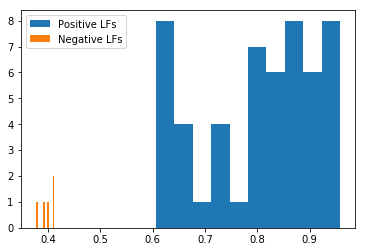

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pos_neg_lf_accs(accs, polarities):
    pos_accs = []
    neg_accs = []
    for i, acc in enumerate(accs):
        if polarities[i] > 0:
            pos_accs.append(acc)
        else:
            neg_accs.append(acc)
    plt.hist(pos_accs, label='Positive LFs')
    plt.hist(neg_accs, label='Negative LFs')
    plt.legend()
    plt.show()

plot_pos_neg_lf_accs(model.accs, polarities)

In [26]:
Yp = model.get_predictions(L.todense())
f1_score(Y, Yp, local=True, average='binary')

[0 0 0 ..., 0 0 0]
[0 0 1 ..., 1 1 1]


0.29431419266611214

In [27]:
0.5 * (np.sum(Y * Yp) / np.abs(Y).sum() + 1)

0.17908984868612904

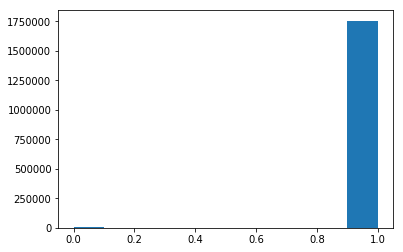

In [28]:
plt.hist(Yp)
plt.show()

### Now try learning the weights with unipolar

In [29]:
model_u = DPModelUnipolar(L, polarities)

In [30]:
train(model_u, n_steps=100, print_at=10, step_size=0.1, l2=0.0)

[Epoch 0] Loss: 0.834713
[Epoch 10] Loss: 0.703697
[Epoch 20] Loss: 0.587598
[Epoch 30] Loss: 0.548607
[Epoch 40] Loss: 0.540369
[Epoch 50] Loss: 0.538014
[Epoch 60] Loss: 0.535351
[Epoch 70] Loss: 0.532181
[Epoch 80] Loss: 0.528976
[Epoch 90] Loss: 0.525923
[Epoch 99] Loss: 0.523349
Finished Training


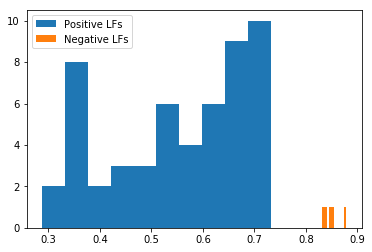

In [31]:
plot_pos_neg_lf_accs(model_u.accs, polarities)

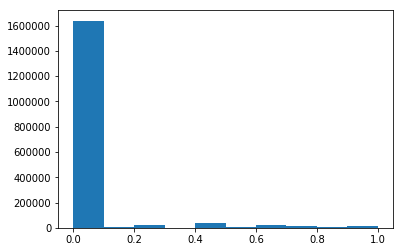

In [32]:
plt.hist(model_u.get_marginals(L.todense()))
plt.show()

In [33]:
Yp_u = model_u.get_predictions(L.todense())
f1_score(Y, Yp_u, local=True, average='binary')

[0 0 0 ..., 0 0 0]
[0 0 1 ..., 0 0 0]


0.036331399598737109

In [34]:
0.5 * (np.sum(Y * Yp_u) / np.abs(Y).sum() + 1)

0.82271112119150225

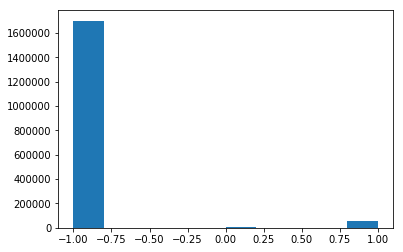

In [35]:
plt.hist(Yp_u)
plt.show()

### Now unipolar imbalanced

In [103]:
from metal.label_models.low_rank import DPModelUnipolarImbalanced

model_ui = DPModelUnipolarImbalanced(L, polarities, y_pos=0.1)
train(model_ui, n_steps=100, print_at=10, step_size=0.1, l2=0.01)

[Epoch 0] Loss: 3.984745
[Epoch 10] Loss: 0.490815
[Epoch 20] Loss: 0.244436
[Epoch 30] Loss: 0.106850
[Epoch 40] Loss: 0.074908
[Epoch 50] Loss: 0.047186
[Epoch 60] Loss: 0.033448
[Epoch 70] Loss: 0.026862
[Epoch 80] Loss: 0.023315
[Epoch 90] Loss: 0.021500
[Epoch 99] Loss: 0.020252
Finished Training


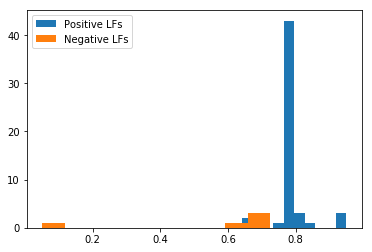

In [104]:
plot_pos_neg_lf_accs(model_ui.accs, polarities)

In [109]:
import pickle

with open('spam_lf_weights.pkl', 'wb') as f:
    pickle.dump(model_ui.accs.numpy(), f)

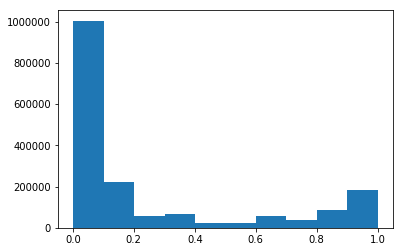

In [106]:
plt.hist(model_ui.get_marginals(L.todense()))
plt.show()

In [107]:
Yp_ui = model_ui.get_predictions(L.todense())
f1_score(Y, Yp_ui, local=True, average='binary')

[1 1 1 ..., 0 0 0]
[1 1 1 ..., 0 0 0]


0.036001047975711624

In [108]:
0.5 * (np.sum(Y * Yp_ui) / np.abs(Y).sum() + 1)

0.43705057014030763

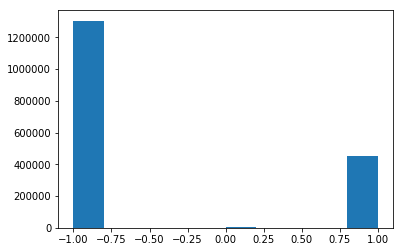

In [85]:
plt.hist(Yp_ui)
plt.show()

### Now try MV

In [44]:
mv = np.where(L.sum(axis=1) > 0, 1, L.sum(axis=1))
mv = np.where(mv < 0, -1, mv)
mv = mv.reshape(-1)

In [76]:
0.5 * (np.sum(Y * mv) / np.abs(Y).sum() + 1)

0.44686940322014523

In [77]:
f1_score(Y, mv, local=True, average='binary')

[1 1 1 ..., 0 0 0]
[1 1 1 ..., 0 0 0]


0.036616715781553698

In [90]:
np.round(np.diag((L.T @ L).todense()), decimals=2)

array([  1.34685700e+06,   7.77230000e+04,   7.99308000e+05,
         1.25927900e+06,   2.11006000e+05,   0.00000000e+00,
         2.69406000e+05,   3.18370000e+04,   1.10936000e+05,
         1.99217000e+05,   7.29100000e+03,   8.08630000e+04,
         1.06250000e+04,   3.26700000e+03,   7.26680000e+04,
         1.53680000e+04,   1.22400000e+04,   1.34450000e+04,
         4.90670000e+04,   4.41900000e+03,   8.25700000e+03,
         5.60900000e+03,   2.15000000e+02,   5.34100000e+03,
         2.59060000e+04,   9.30500000e+03,   2.37600000e+03,
         1.26700000e+03,   2.70600000e+03,   5.80000000e+03,
         6.31000000e+02,   4.44000000e+02,   7.91000000e+02,
         9.96000000e+02,   1.83700000e+03,   2.85900000e+03,
         8.25000000e+02,   4.08000000e+02,   8.12000000e+02,
         6.12000000e+02,   5.61000000e+02,   1.67000000e+02,
         2.00000000e+02,   9.00000000e+01,   1.00000000e+02,
         1.00000000e+02,   5.30000000e+01,   1.01000000e+02,
         5.30000000e+01,

In [97]:
model_ui.beta

Parameter containing:
 0.8376
 0.2508
 0.5711
 0.7981
 0.3833
 0.2155
 0.2547
 0.2328
 0.2855
 0.3501
 0.2237
 0.2590
 0.2256
 0.2160
 0.0950
 0.2275
 0.2277
 0.2274
 0.2509
 0.2169
 0.2198
 0.2219
 0.2156
 0.2180
 0.2300
 0.2220
 0.2163
 0.2175
 0.2201
 0.2206
 0.2160
 0.2160
 0.2162
 0.2159
 0.2167
 0.2191
 0.2159
 0.2157
 0.2159
 0.2162
 0.2159
 0.2157
 0.2157
 0.2157
 0.2155
 0.2155
 0.2156
 0.2156
 0.2156
 0.2156
 0.2156
 0.2155
 0.2155
 0.2155
 0.2155
 0.2155
 0.2156
 0.2155
[torch.FloatTensor of size 58x1]